In [1]:
import sys
from pyspark.sql import SparkSession
spark = (SparkSession
 .builder
 .master("local")
 .appName("Padron")
 .getOrCreate())

# Ejercicio 1

Comenzamos realizando la misma práctica que hicimos en Hive en Spark, importando el 
csv. Sería recomendable intentarlo con opciones que quiten las "" de los campos, que 
ignoren los espacios innecesarios en los campos, que sustituyan los valores vacíos por 0 y 
que infiera el esquema.

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType

# Leemos los datos y quitamos filas con NA y convertimos a numéricas las columnas inferidas incorrectamente
padron_lectura = spark.read\
                 .option("header", "true")\
                 .option("delimiter", ";")\
                 .option("inferSchema", "true")\
                 .option("quote", "\"")\
                 .csv("C:/Shared/Rango_Edades_Seccion_202204.csv")

In [3]:
padron_lectura.show(truncate = True)

+------------+--------------------+---------------+--------------------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|COD_DISTRITO|       DESC_DISTRITO|COD_DIST_BARRIO|         DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|
+------------+--------------------+---------------+--------------------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|           1|CENTRO              |            101|PALACIO             |         1|            1001|          1|           0|               3|               1|                 1|              null|
|           1|CENTRO              |            101|PALACIO             |         1|            1001|          1|           1|               5|               2|              null|              null|
|         

Vemos el esquema

In [4]:
padron_lectura.printSchema()


root
 |-- COD_DISTRITO: integer (nullable = true)
 |-- DESC_DISTRITO: string (nullable = true)
 |-- COD_DIST_BARRIO: integer (nullable = true)
 |-- DESC_BARRIO: string (nullable = true)
 |-- COD_BARRIO: integer (nullable = true)
 |-- COD_DIST_SECCION: integer (nullable = true)
 |-- COD_SECCION: integer (nullable = true)
 |-- COD_EDAD_INT: integer (nullable = true)
 |-- EspanolesHombres: integer (nullable = true)
 |-- EspanolesMujeres: integer (nullable = true)
 |-- ExtranjerosHombres: integer (nullable = true)
 |-- ExtranjerosMujeres: integer (nullable = true)



Vamos a reemplazar los valore null y a hacer un trim de las columnas con strings

In [5]:
padron_limpio = padron_lectura.withColumn("DESC_DISTRITO", F.trim(F.col("DESC_DISTRITO")))\
                      .withColumn("DESC_BARRIO", F.trim(F.col("DESC_BARRIO")))\
                      .na.fill(0, ["EspanolesHombres", "EspanolesMujeres", "ExtranjerosHombres", "ExtranjerosMujeres"]).cache()


padron_limpio.show()

+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|COD_DISTRITO|DESC_DISTRITO|COD_DIST_BARRIO|DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|
+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|           1|       CENTRO|            101|    PALACIO|         1|            1001|          1|           0|               3|               1|                 1|                 0|
|           1|       CENTRO|            101|    PALACIO|         1|            1001|          1|           1|               5|               2|                 0|                 0|
|           1|       CENTRO|            101|    PALACIO|         1|            1001|      

# Ejercicio 2

De manera alternativa también se puede importar el csv con menos tratamiento en la 
importación y hacer todas las modificaciones para alcanzar el mismo estado de limpieza de
los datos con funciones de Spark.

In [6]:
padron_limpio.show()

+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|COD_DISTRITO|DESC_DISTRITO|COD_DIST_BARRIO|DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|
+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|           1|       CENTRO|            101|    PALACIO|         1|            1001|          1|           0|               3|               1|                 1|                 0|
|           1|       CENTRO|            101|    PALACIO|         1|            1001|          1|           1|               5|               2|                 0|                 0|
|           1|       CENTRO|            101|    PALACIO|         1|            1001|      

# Ejercicio 3

Enumera todos los barrios diferentes.

In [7]:
padron_limpio.select(F.col("DESC_BARRIO")).distinct().show()

+--------------------+
|         DESC_BARRIO|
+--------------------+
|        VALDEFUENTES|
|       LOS JERONIMOS|
|            ABRANTES|
|          NI�O JESUS|
|            VALVERDE|
|              CORTES|
|   PALOMERAS SURESTE|
|CIUDAD UNIVERSITARIA|
|      CUATRO VIENTOS|
|           TRAFALGAR|
|              HELLIN|
|    ALAMEDA DE OSUNA|
|          PRADOLONGO|
|            MOSCARDO|
|          VALDEZARZA|
|           RECOLETOS|
|             HORCAJO|
|        VISTA ALEGRE|
|             EL VISO|
|    PUERTA DEL ANGEL|
+--------------------+
only showing top 20 rows



# Ejercicio 4

Crea una vista temporal de nombre "padron" y a través de ella cuenta el número de barrios
diferentes que hay.

In [8]:
padron_limpio.createOrReplaceTempView("padron")

In [9]:
spark.sql("SELECT COUNT(DISTINCT  DESC_BARRIO) FROM padron").show()

+---------------------------+
|count(DISTINCT DESC_BARRIO)|
+---------------------------+
|                        132|
+---------------------------+



# Ejercicio 5

Crea una nueva columna que muestre la longitud de los campos de la columna 
DESC_DISTRITO y que se llame "longitud".

In [10]:
padron_5 = padron_limpio.withColumn("longitud", F.length(F.col("DESC_DISTRITO")))

In [11]:
padron_5.show(truncate= True)

+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+--------+
|COD_DISTRITO|DESC_DISTRITO|COD_DIST_BARRIO|DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|longitud|
+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+--------+
|           1|       CENTRO|            101|    PALACIO|         1|            1001|          1|           0|               3|               1|                 1|                 0|       6|
|           1|       CENTRO|            101|    PALACIO|         1|            1001|          1|           1|               5|               2|                 0|                 0|       6|
|           1|       CENTRO|            101| 

# Ejercicio 6

Crea una nueva columna que muestre el valor 5 para cada uno de los registros de la tabla. 

In [12]:
padron_6 = padron_limpio.withColumn("valor_5", F.lit(5))

In [13]:
padron_6.show()

+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+-------+
|COD_DISTRITO|DESC_DISTRITO|COD_DIST_BARRIO|DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|valor_5|
+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+-------+
|           1|       CENTRO|            101|    PALACIO|         1|            1001|          1|           0|               3|               1|                 1|                 0|      5|
|           1|       CENTRO|            101|    PALACIO|         1|            1001|          1|           1|               5|               2|                 0|                 0|      5|
|           1|       CENTRO|            101|    PA

In [14]:
padron_6.printSchema()

root
 |-- COD_DISTRITO: integer (nullable = true)
 |-- DESC_DISTRITO: string (nullable = true)
 |-- COD_DIST_BARRIO: integer (nullable = true)
 |-- DESC_BARRIO: string (nullable = true)
 |-- COD_BARRIO: integer (nullable = true)
 |-- COD_DIST_SECCION: integer (nullable = true)
 |-- COD_SECCION: integer (nullable = true)
 |-- COD_EDAD_INT: integer (nullable = true)
 |-- EspanolesHombres: integer (nullable = true)
 |-- EspanolesMujeres: integer (nullable = true)
 |-- ExtranjerosHombres: integer (nullable = true)
 |-- ExtranjerosMujeres: integer (nullable = true)
 |-- valor_5: integer (nullable = false)



# Ejercicio 7

Borra esta columna.


In [15]:
padron_7 = padron_6.drop(F.col("valor_5"))

In [16]:
padron_7.show()

+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|COD_DISTRITO|DESC_DISTRITO|COD_DIST_BARRIO|DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|
+------------+-------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|           1|       CENTRO|            101|    PALACIO|         1|            1001|          1|           0|               3|               1|                 1|                 0|
|           1|       CENTRO|            101|    PALACIO|         1|            1001|          1|           1|               5|               2|                 0|                 0|
|           1|       CENTRO|            101|    PALACIO|         1|            1001|      

# Ejercicio 8

Particiona el DataFrame por las variables DESC_DISTRITO y DESC_BARRIO.

In [17]:

padron_8 = padron_limpio.repartition("DESC_DISTRITO", "DESC_BARRIO")


padron_8.show()

+------------+-------------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|COD_DISTRITO|      DESC_DISTRITO|COD_DIST_BARRIO|DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|
+------------+-------------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+
|           8|FUENCARRAL-EL PARDO|            807| MIRASIERRA|         7|            8131|        131|           0|               9|               2|                 1|                 0|
|           8|FUENCARRAL-EL PARDO|            807| MIRASIERRA|         7|            8131|        131|           1|              11|              12|                 0|                 0|
|           8|FUENCARRAL-EL PARDO|            807| MIRASIERR

# Ejercicio 9

Almacénalo en caché. Consulta en el puerto 4040 (UI de Spark) de tu usuario local el estado
de los rdds almacenados.

In [18]:
padron_9 = padron_8.cache()

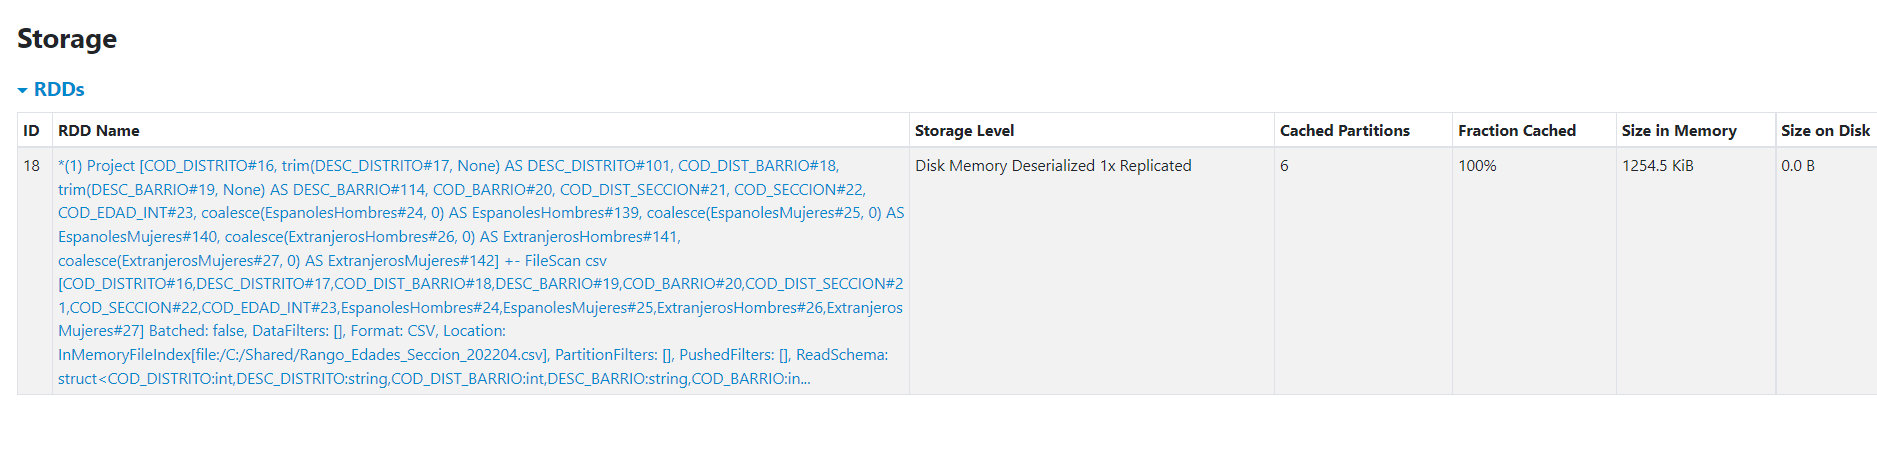

# Ejercicio 10

Lanza una consulta contra el DF resultante en la que muestre el número total de 
"espanoleshombres", "espanolesmujeres", extranjeroshombres" y "extranjerosmujeres" 
para cada barrio de cada distrito. Las columnas distrito y barrio deben ser las primeras en 
aparecer en el show. Los resultados deben estar ordenados en orden de más a menos 
según la columna "extranjerosmujeres" y desempatarán por la columna 
"extranjeroshombres".

In [19]:
padron_10 = padron_9.groupBy("DESC_DISTRITO", "DESC_BARRIO").agg(F.count("EspanolesHombres").alias("NumEspHom"),
                                                                 F.count("EspanolesMujeres").alias("NumEspMuj"), 
                                                                 F.count("ExtranjerosHombres").alias("NumExHom"), 
                                                                 F.count("ExtranjerosMujeres").alias("NumExMuj"))\
                                                            .orderBy(F.col("NumExMuj").desc(), F.col("NumExHom").desc())

padron_10.show()

+-------------------+--------------------+---------+---------+--------+--------+
|      DESC_DISTRITO|         DESC_BARRIO|NumEspHom|NumEspMuj|NumExHom|NumExMuj|
+-------------------+--------------------+---------+---------+--------+--------+
|             LATINA|              ALUCHE|     5750|     5750|    5750|    5750|
|      CIUDAD LINEAL|        PUEBLO NUEVO|     4498|     4498|    4498|    4498|
|FUENCARRAL-EL PARDO|            EL PILAR|     4370|     4370|    4370|    4370|
|             LATINA|         LAS AGUILAS|     4100|     4100|    4100|    4100|
|          HORTALEZA|       PINAR DEL REY|     4078|     4078|    4078|    4078|
|      CIUDAD LINEAL|              VENTAS|     4026|     4026|    4026|    4026|
|FUENCARRAL-EL PARDO|            VALVERDE|     3801|     3801|    3801|    3801|
|             LATINA|    PUERTA DEL ANGEL|     3630|     3630|    3630|    3630|
|FUENCARRAL-EL PARDO|         PE�A GRANDE|     3513|     3513|    3513|    3513|
|             CENTRO|       

# Ejercicio 11


Elimina el registro en caché.


In [20]:
padron_9.unpersist()

DataFrame[COD_DISTRITO: int, DESC_DISTRITO: string, COD_DIST_BARRIO: int, DESC_BARRIO: string, COD_BARRIO: int, COD_DIST_SECCION: int, COD_SECCION: int, COD_EDAD_INT: int, EspanolesHombres: int, EspanolesMujeres: int, ExtranjerosHombres: int, ExtranjerosMujeres: int]

# Ejercicio 12

Crea un nuevo DataFrame a partir del original que muestre únicamente una columna con 
DESC_BARRIO, otra con DESC_DISTRITO y otra con el número total de "espanoleshombres" 
residentes en cada distrito de cada barrio. Únelo (con un join) con el DataFrame original a 
través de las columnas en común.

In [21]:
padron_12 = padron_limpio.groupBy("DESC_DISTRITO", "DESC_BARRIO").agg(F.sum("EspanolesHombres").alias("SumEspHom"))


padron_12.show()

+-------------------+-----------------+---------+
|      DESC_DISTRITO|      DESC_BARRIO|SumEspHom|
+-------------------+-----------------+---------+
|FUENCARRAL-EL PARDO|       MIRASIERRA|    16342|
|          SALAMANCA|       CASTELLANA|     6046|
|SAN BLAS-CANILLEJAS|      EL SALVADOR|     4854|
|    MONCLOA-ARAVACA|    CASA DE CAMPO|     5397|
|          HORTALEZA|     VALDEFUENTES|    29749|
|          MORATALAZ|       MARROQUINA|    11328|
|             TETUAN|    BELLAS VISTAS|    10197|
|          VICALVARO|     EL CA�AVERAL|     4565|
|             CENTRO|         JUSTICIA|     6937|
|             CENTRO|      UNIVERSIDAD|    12248|
|      CIUDAD LINEAL|          ATALAYA|      622|
|             TETUAN|       BERRUGUETE|     8649|
|          VICALVARO|CASCO H.VICALVARO|    13275|
|          CHAMARTIN|         CASTILLA|     7146|
|         ARGANZUELA|          LEGAZPI|     8839|
|SAN BLAS-CANILLEJAS|           HELLIN|     3579|
|          CHAMARTIN|   HISPANOAMERICA|    13193|


In [22]:
padron_12_join = padron_limpio.join(padron_12, on = ["DESC_DISTRITO", "DESC_BARRIO"])

padron_12_join.show()

+-------------+-----------+------------+---------------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+---------+
|DESC_DISTRITO|DESC_BARRIO|COD_DISTRITO|COD_DIST_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|SumEspHom|
+-------------+-----------+------------+---------------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+---------+
|       CENTRO|    PALACIO|           1|            101|         1|            1001|          1|           0|               3|               1|                 1|                 0|     9205|
|       CENTRO|    PALACIO|           1|            101|         1|            1001|          1|           1|               5|               2|                 0|                 0|     9205|
|       CENTRO|    PALACIO|           1|

# Ejercicio 13

Repite la función anterior utilizando funciones de ventana. (over(Window.partitionBy.....)).

In [23]:
from pyspark.sql import Window
w = Window().partitionBy("DESC_DISTRITO", "DESC_BARRIO")

In [24]:
padron_13 = padron_limpio.withColumn("SumEspHom", F.sum("EspanolesHombres").over(w))

In [25]:
padron_13.show()

+------------+-------------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+---------+
|COD_DISTRITO|      DESC_DISTRITO|COD_DIST_BARRIO|DESC_BARRIO|COD_BARRIO|COD_DIST_SECCION|COD_SECCION|COD_EDAD_INT|EspanolesHombres|EspanolesMujeres|ExtranjerosHombres|ExtranjerosMujeres|SumEspHom|
+------------+-------------------+---------------+-----------+----------+----------------+-----------+------------+----------------+----------------+------------------+------------------+---------+
|           8|FUENCARRAL-EL PARDO|            807| MIRASIERRA|         7|            8131|        131|           0|               9|               2|                 1|                 0|    16342|
|           8|FUENCARRAL-EL PARDO|            807| MIRASIERRA|         7|            8131|        131|           1|              11|              12|                 0|                 0|    16342|
|         

# Ejercicio 14

Mediante una función Pivot muestra una tabla (que va a ser una tabla de contingencia) que
contenga los valores totales ()la suma de valores) de espanolesmujeres para cada distrito y 
en cada rango de edad (COD_EDAD_INT). Los distritos incluidos deben ser únicamente 
CENTRO, BARAJAS y RETIRO y deben figurar como columnas . El aspecto debe ser similar a 
este:

In [26]:
w2 = Window().partitionBy("DESC_DISTRITO", "COD_EDAD_INT")

padron_14 = padron_limpio.where((F.col("DESC_DISTRITO") == "CENTRO") | (F.col("DESC_DISTRITO") == "BARAJAS") | (F.col("DESC_DISTRITO") == "RETIRO") )\
                         .groupBy( "COD_EDAD_INT").pivot("DESC_DISTRITO")\
                         .agg(F.sum(F.col("Espanolesmujeres")))\
                         .orderBy(F.col("COD_EDAD_INT").asc())

In [27]:
padron_14.show()

+------------+-------+------+------+
|COD_EDAD_INT|BARAJAS|CENTRO|RETIRO|
+------------+-------+------+------+
|           0|    146|   262|   317|
|           1|    160|   240|   318|
|           2|    171|   200|   377|
|           3|    175|   216|   365|
|           4|    201|   239|   412|
|           5|    217|   224|   420|
|           6|    242|   231|   405|
|           7|    229|   237|   466|
|           8|    234|   228|   417|
|           9|    236|   235|   421|
|          10|    260|   252|   419|
|          11|    241|   231|   423|
|          12|    259|   244|   417|
|          13|    267|   274|   443|
|          14|    250|   249|   407|
|          15|    269|   251|   429|
|          16|    269|   267|   422|
|          17|    265|   261|   417|
|          18|    223|   285|   455|
|          19|    254|   304|   411|
+------------+-------+------+------+
only showing top 20 rows



# Ejercicio 15

Utilizando este nuevo DF, crea 3 columnas nuevas que hagan referencia a qué porcentaje 
de la suma de "espanolesmujeres" en los tres distritos para cada rango de edad representa 
cada uno de los tres distritos. Debe estar redondeada a 2 decimales. Puedes imponerte la 
condición extra de no apoyarte en ninguna columna auxiliar creada para el caso.

In [28]:
padron_15 = padron_14.withColumn("suma", F.col("BARAJAS")+F.col("CENTRO")+ F.col("RETIRO"))\
                     .withColumn("PorcBARAJAS", F.col("BARAJAS")/F.col("suma")*100)\
                     .withColumn("PorcCENTRO", F.col("CENTRO")/F.col("suma")*100)\
                     .withColumn("PorcRETIRO", F.col("RETIRO")/F.col("suma")*100)\
                     .drop("suma")

padron_15.show()

+------------+-------+------+------+------------------+------------------+------------------+
|COD_EDAD_INT|BARAJAS|CENTRO|RETIRO|       PorcBARAJAS|        PorcCENTRO|        PorcRETIRO|
+------------+-------+------+------+------------------+------------------+------------------+
|           0|    146|   262|   317|20.137931034482758|36.137931034482754|43.724137931034484|
|           1|    160|   240|   318|22.284122562674096| 33.42618384401114| 44.28969359331476|
|           2|    171|   200|   377| 22.86096256684492|26.737967914438503| 50.40106951871658|
|           3|    175|   216|   365| 23.14814814814815| 28.57142857142857| 48.28042328042328|
|           4|    201|   239|   412|23.591549295774648|28.051643192488264| 48.35680751173709|
|           5|    217|   224|   420|25.203252032520325| 26.01626016260163| 48.78048780487805|
|           6|    242|   231|   405|  27.5626423690205| 26.30979498861048| 46.12756264236902|
|           7|    229|   237|   466|24.570815450643778|25.42

# Ejercicio 16

Guarda el archivo csv original particionado por distrito y por barrio (en ese orden) en un 
directorio local. Consulta el directorio para ver la estructura de los ficheros y comprueba 
que es la esperada.

In [37]:

padron_limpio.write.option("header",True).partitionBy("DESC_DISTRITO", "DESC_BARRIO").mode('overwrite').format("csv").save("C:/PracticaPadron")

# Ejercicio 17

Haz el mismo guardado pero en formato parquet. Compara el peso del archivo con el 
resultado anterior.

In [38]:

padron_limpio.write.option("header",True).partitionBy("DESC_DISTRITO", "DESC_BARRIO").mode('overwrite').format("parquet").save("C:/PracticaPadronParquet")

In [3]:
spark.sql("SELECT * FROM datos_padron.padron_txt").collect()

AnalysisException: Table or view not found: datos_padron.padron_txt; line 1 pos 14;
'Project [*]
+- 'UnresolvedRelation [datos_padron, padron_txt], [], false


In [2]:
spark.sql("Show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
+--------+---------+-----------+

